### 1. 라이브러리 호출

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### 2. 데이터 불러오기

In [14]:
# 건물정보 데이터셋
building = pd.read_csv('data/building_info.csv')

# 날씨/전력사용량 데이터셋 (건물/시간대별)
train = pd.read_csv('data/train.csv')

# 날씨/전력사용량 데이터셋 (건물/시간대별)
test = pd.read_csv('data/test.csv')

### 3. 기본 데이터셋 확인

In [3]:
# 빌딩 정보 데이터
building.head(5)

,건물번호,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW)
0,1,건물기타,110634.00,39570.00,-,-,-
1,2,건물기타,122233.47,99000.00,-,-,-
2,3,건물기타,171243.00,113950.00,40,-,-
3,4,건물기타,74312.98,34419.62,60,-,-
4,5,건물기타,205884.00,150000.00,-,2557,1000


In [4]:
# train(날씨/전력사용량) 데이터셋 
train.head(5)

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
0,1_20220601 00,1,20220601 00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28
1,1_20220601 01,1,20220601 01,18.0,NaN,1.1,45.0,NaN,NaN,1047.36
2,1_20220601 02,1,20220601 02,17.7,NaN,1.5,45.0,NaN,NaN,974.88
3,1_20220601 03,1,20220601 03,16.7,NaN,1.4,48.0,NaN,NaN,953.76
4,1_20220601 04,1,20220601 04,18.4,NaN,2.8,43.0,NaN,NaN,986.40


In [5]:
# 테스트 데이터셋
test.head(5)

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%)
0,1_20220825 00,1,20220825 00,23.5,0.0,2.2,72
1,1_20220825 01,1,20220825 01,23.0,0.0,0.9,72
2,1_20220825 02,1,20220825 02,22.7,0.0,1.5,75
3,1_20220825 03,1,20220825 03,22.1,0.0,1.3,78
4,1_20220825 04,1,20220825 04,21.8,0.0,1.0,77


### 4. 빌딩 정보 데이터

In [15]:
# 빌딩 정보 데이터에는 결측치가 없음을 확인할 수 있다.
# 하지만 '-'으로 결측치가 표시되어 있기 때문에 다른 방식으로 결측치를 확인해야 함
# 따라서 '-'로 되어 있는 값을 NAN 값으로 변경하는 과정이 필요하다.
building = building.replace('-', np.nan)

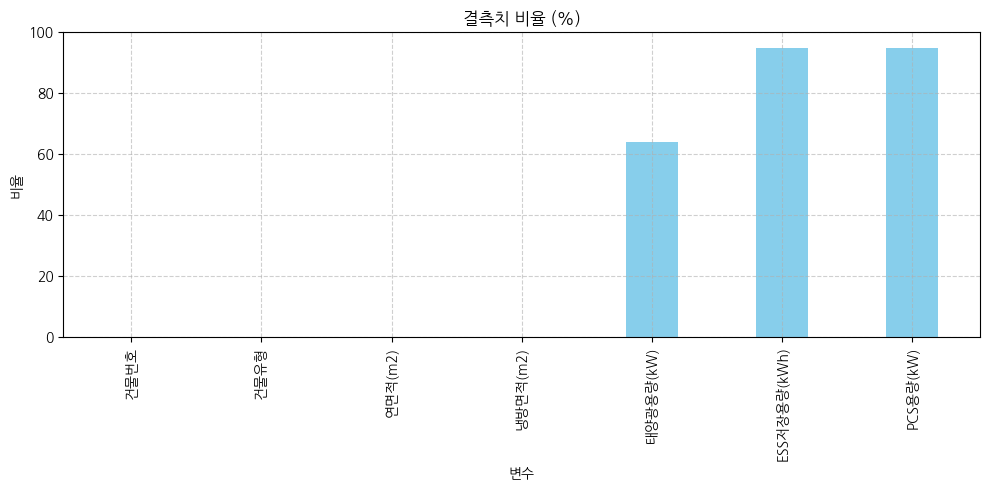

In [16]:
# 결측치 비율에 관한 시각화

# 한글폰트 사용: 'NanumGothic' 폰트를 사용합니다.
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 문제 해결

# 각 컬럼별 결측치 수 계산
missing_counts = building.isnull().sum()

# 데이터의 전체 행 수
total_rows = building.shape[0]  # 수정된 부분: len() 대신 .shape[0] 사용

# 결측치 비율 계산
missing_ratio = (missing_counts / total_rows) * 100

# 막대 그래프로 시각화
plt.figure(figsize=(10, 5))  # 그래프 크기 설정
plt.bar(missing_ratio.index, missing_ratio, color='skyblue', width=0.4)  # 막대 너비 조정
plt.title('결측치 비율 (%)')
plt.xlabel('변수')
plt.ylabel('비율')
plt.ylim(0, 100)  # y축 범위 설정
plt.xticks(rotation=90)  # x축 레이블을 세로로 설정
plt.grid(True, linestyle='--', alpha=0.6)  # 격자 추가
plt.tight_layout()  # 레이아웃을 조정하여 레이블이 잘리지 않도록 함
plt.show()


### 5. 학습 데이터

In [17]:
# 주말/공휴일 컬럼 만들기
train['일시'] = pd.to_datetime(train['일시'], format = '%Y%m%d %H')
def is_holiday(row):
    if row['일시'].date() in [pd.to_datetime('2022-06-06').date(), pd.to_datetime('2022-08-15').date()]:
        return 1
    elif row['일시'].dayofweek >= 5:  # 토요일(5) 또는 일요일(6)인 경우
        return 1
    else:
        return 0
train['휴일'] = train.apply(is_holiday, axis=1)

# 일시를 년, 월, 일 컬럼으로 분리(train)
train['년'] = train['일시'].dt.year
train['월'] = train['일시'].dt.month
train['일'] = train['일시'].dt.day
train['시'] = train['일시'].dt.hour
train.drop(['num_date_time', '일시', '년'], axis=1, inplace=True)

# 시간 데이터 표준화
train['sin_time'] = np.sin(2*np.pi*train['시']/24)
train['cos_time'] = np.cos(2*np.pi*train['시']/24)

# 공통된 건물번호 컬럼을 기준으로 데이터 병합
train = pd.merge(building, train, on = '건물번호')

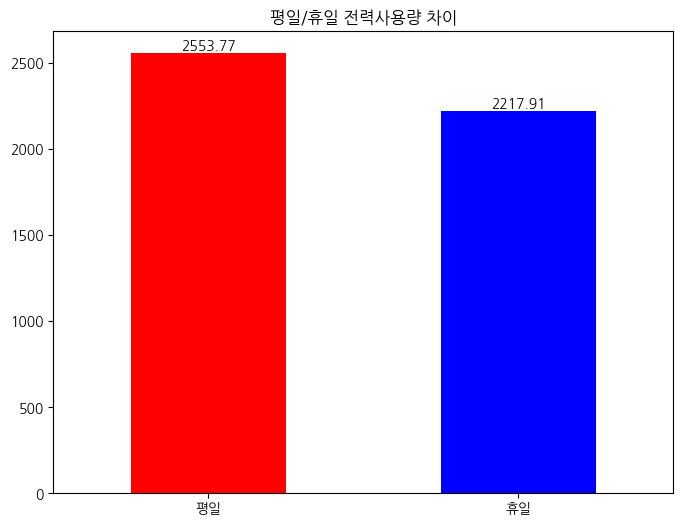

In [18]:
# 휴일과 평일의 전력사용량 

# 한글폰트 사용: 'NanumGothic' 폰트를 사용합니다.
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 문제 해결

# 평균 전력 소비량 계산
average_power = train.groupby('휴일')['전력소비량(kWh)'].mean()

# 시각화 (xlabel 제거)
plt.figure(figsize=(8,6))
ax = average_power.plot(kind='bar', color=['red', 'blue'])
plt.title('평일/휴일 전력사용량 차이')
plt.xlabel('')  # x축 레이블 삭제

# x축 레이블
ax.set_xticklabels(['평일', '휴일'], rotation=0)

# 바 위에 값 표시
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

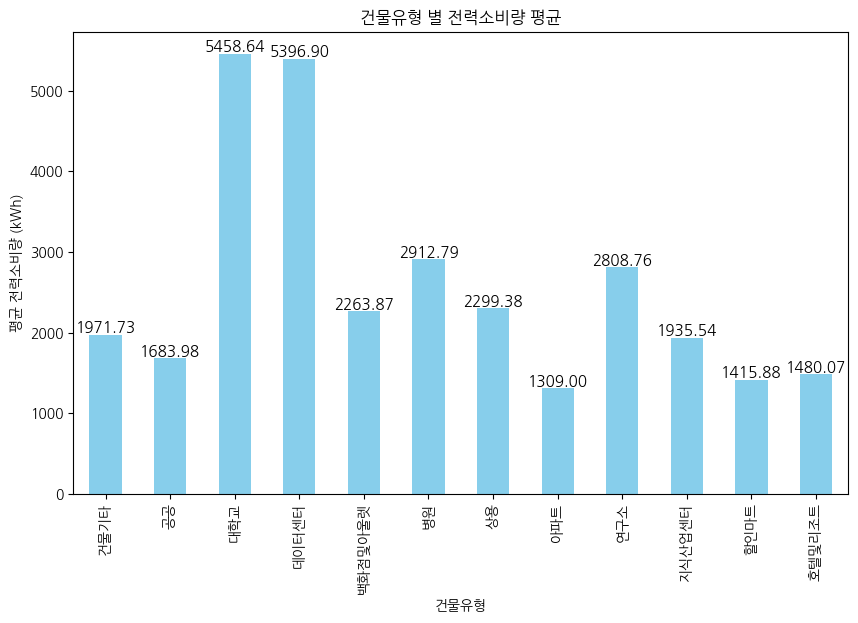

In [19]:
# 건물유형 별 평균 전력 소비량 계산
average_power_by_type = train.groupby('건물유형')['전력소비량(kWh)'].mean()

# 시각화 설정
plt.figure(figsize=(10, 6))
ax = average_power_by_type.plot(kind='bar', color='skyblue')
plt.title('건물유형 별 전력소비량 평균')
plt.xlabel('건물유형')
plt.ylabel('평균 전력소비량 (kWh)')

# 바 위에 평균값 표시
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

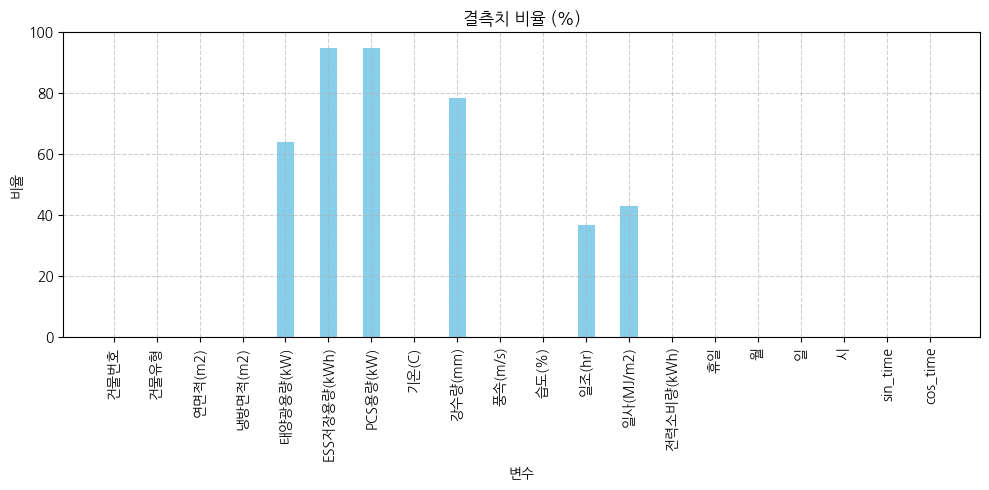

In [20]:
# 결측치 비율에 관한 시각화

# 한글폰트 사용: 'NanumGothic' 폰트를 사용합니다.
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 문제 해결

# 각 컬럼별 결측치 수 계산
missing_counts = train.isnull().sum()

# 데이터의 전체 행 수
total_rows = train.shape[0]  # 수정된 부분: len() 대신 .shape[0] 사용

# 결측치 비율 계산
missing_ratio = (missing_counts / total_rows) * 100

# 막대 그래프로 시각화
plt.figure(figsize=(10, 5))  # 그래프 크기 설정
plt.bar(missing_ratio.index, missing_ratio, color='skyblue', width=0.4)  # 막대 너비 조정
plt.title('결측치 비율 (%)')
plt.xlabel('변수')
plt.ylabel('비율')
plt.ylim(0, 100)  # y축 범위 설정
plt.xticks(rotation=90)  # x축 레이블을 세로로 설정
plt.grid(True, linestyle='--', alpha=0.6)  # 격자 추가
plt.tight_layout()  # 레이아웃을 조정하여 레이블이 잘리지 않도록 함
plt.show()


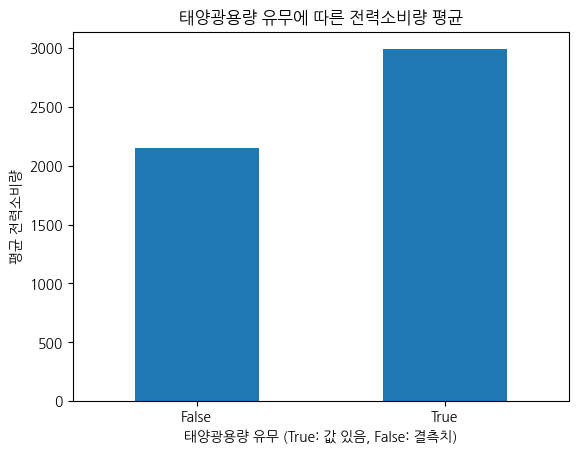

In [21]:
# 태양광용량 유무에 따른 전력사용량 비교 시각화

train.groupby(train['태양광용량(kW)'].notnull())['전력소비량(kWh)'].mean().plot(kind='bar', title='태양광용량 유무에 따른 전력소비량 평균')
plt.xlabel('태양광용량 유무 (True: 값 있음, False: 결측치)')
plt.ylabel('평균 전력소비량')
plt.xticks(rotation=0)
plt.show()